**CNN Model to detect whether an XRay scan image has a fracture or not text**

---
This is an example of a binary classifaction (fractured/non-fractured).

Mount google drive, so as to load the Fractures XRay images. The images are 1560 x 1170 pixels.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DATA_DIR = "/content/drive/MyDrive/FractureXRayImages"

In [3]:
import pathlib

data_dir = pathlib.Path(DATA_DIR).with_suffix('')

Get a count of items in the dataset

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

90


The dataset has only 90 images which is small for machine learning purposes. Ideally, we need a lot more data points to create an effective model. But, given this dataset, we will see if we can create a model that will be useful.

In [5]:
batch_size = 5
img_height = 1560
img_width = 1170

Load the images to a Pandas dataframe. We will do a 80-20 split for training vs validation. The images are imported as grayscale.

In [6]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 90 files belonging to 2 classes.
Using 72 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 90 files belonging to 2 classes.
Using 18 files for validation.


Determine the label names for the classification. These are inferred by the subfolder names in the Google drive. The load image from directory function automatically infers the class names to match the subfolder names.

In [8]:
class_names = train_ds.class_names
print(class_names)

['fractured', 'non fractured']


Plot a few sample images.

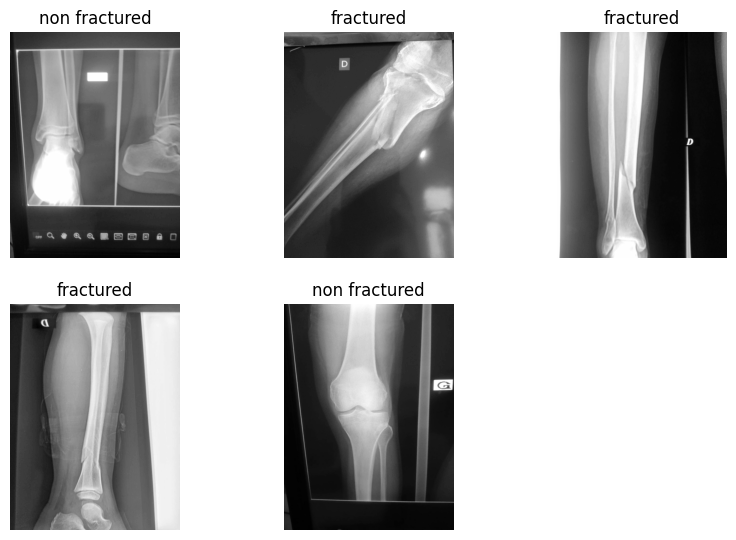

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(5, 1560, 1170, 1)
(5,)


Update the image datasets to use some optimization so they can perform perform better when training the model.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Import the necessary ML Libraries (Keras, Numpy etc.)

In [ ]:
import numpy as np
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Create a basic CNN model for image processing and classification. This model consists of three Convolution layers with MaxPooling (2x2) and a dense layer followed by the final classification layer.

This does not have regularization so we can first evaluate if this model is overfitting, if it does we can add this later.

In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation=None, name='outputs')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We will use binary cross entropy for the loss function since this is a binary classification problem.

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

Adding early stopping conditions. This is only regularization so we can stop early if the model takes a lot of time to train on the images.

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto', restore_best_weights=True)
checkpoint = ModelCheckpoint('model_weights.h5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

callbacks = [early_stopping, checkpoint, reduce_lr]

In [ ]:
epochs=20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6475 - loss: 16.6892 
Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to model_weights.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 309s 21s/step - accuracy: 0.6435 - loss: 16.5424 - val_accuracy: 0.8333 - val_loss: 0.4193 - learning_rate: 0.0010
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8750 - loss: 0.3220 
Epoch 2: val_accuracy did not improve from 0.83333
15/15 ━━━━━━━━━━━━━━━━━━━━ 241s 15s/step - accuracy: 0.8715 - loss: 0.3277 - val_accuracy: 0.8333 - val_loss: 0.3412 - learning_rate: 0.0010
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9722 - loss: 0.1485 
Epoch 3: val_accuracy improved from 0.83333 to 0.94444, saving model to model_weights.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 305s 21s/step - accuracy: 0.9705 - loss: 0.1519 - val_accuracy: 0.9444 - val_loss: 0.4091 - learning_rate: 0.0010
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9803 - loss: 0.107

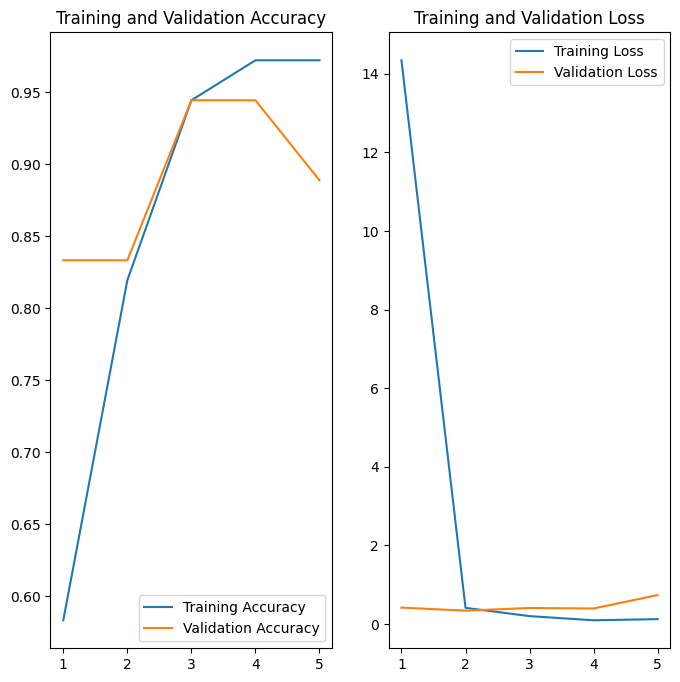

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model seems to be overfitting so we can try to introduce some regularization so it can generalize well for the entire dataset.

### Strategies to limit overfitting

* Increasing training data size (unfortunately this dataset size is limited, so this is not an option)
* Data augmentation to increase data complexity
* Adding dropout layers
* Adding Regularization parameters (e.g. kernel_regularizer=regularizers.l2(l=0.01))
* Adding batch normalization
* Early stopping
* Simplifying the model (reducing the number of layers)

Using data augmentation to introduce some randomization to the images.

In [15]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode="horizontal", seed=42, input_shape=(img_height, img_width, 1)),
    layers.RandomRotation(factor=0.05, seed=42),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


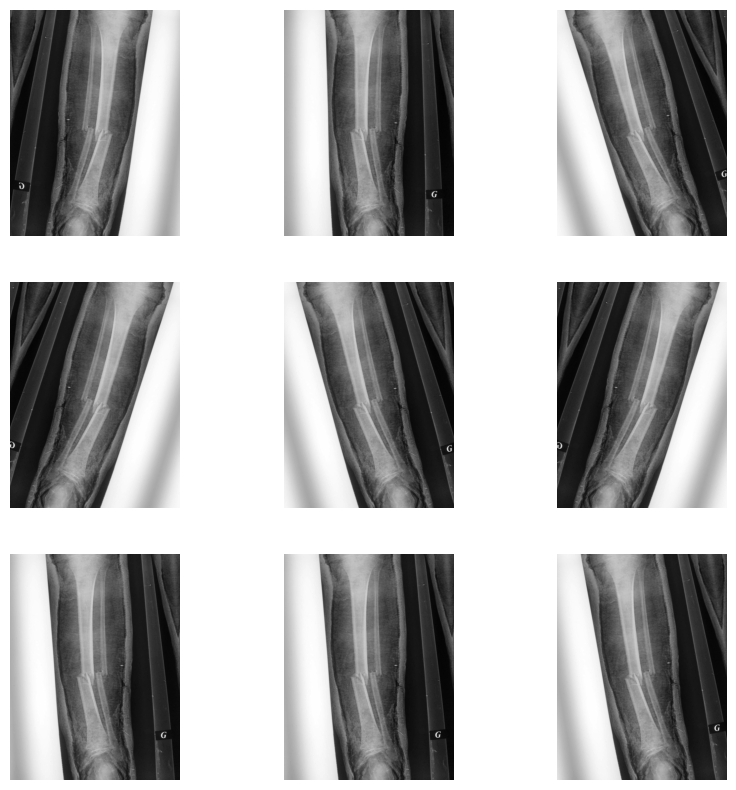

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap="gray")
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu',),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation=None, name="outputs")
])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 1560, 1170, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 1560, 1170, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 1560, 1170, 16)      │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 780, 585, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 780, 585, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 390, 292, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 390, 292, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 195, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 195, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1822080)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     233,226,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,249,793 (889.78 MB)

 Trainable params: 233,249,793 (889.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6467 - loss: 7.9920 
Epoch 1: val_accuracy improved from -inf to 0.61111, saving model to model_weights.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 327s 22s/step - accuracy: 0.6453 - loss: 7.9501 - val_accuracy: 0.6111 - val_loss: 0.7323 - learning_rate: 0.0010
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6300 - loss: 0.6764 
Epoch 2: val_accuracy improved from 0.61111 to 0.66667, saving model to model_weights.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 448s 27s/step - accuracy: 0.6358 - loss: 0.6683 - val_accuracy: 0.6667 - val_loss: 0.7302 - learning_rate: 0.0010
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8097 - loss: 0.4653 
Epoch 3: val_accuracy improved from 0.66667 to 0.72222, saving model to model_weights.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 394s 23s/step - accuracy: 0.8129 - loss: 0.4594 - val_accuracy: 0.7222 - val_loss: 0.8463 - learning_rate: 0.0010
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s

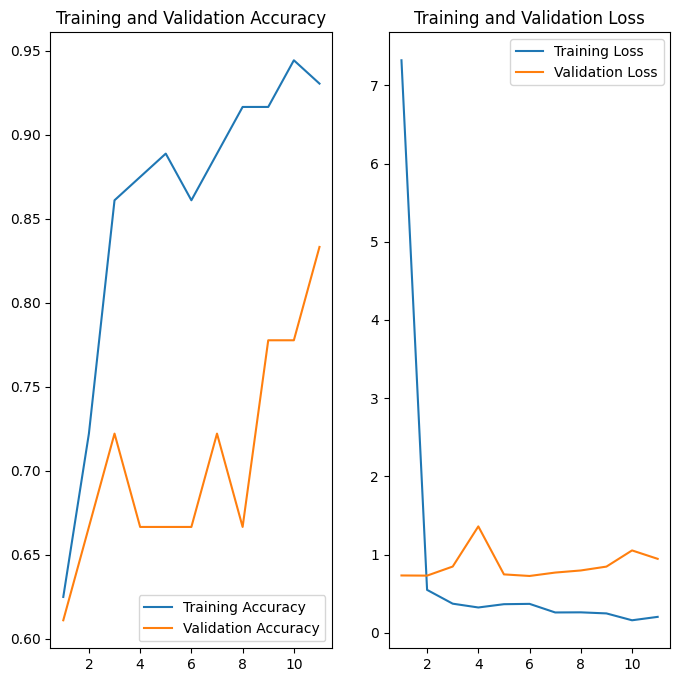

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Let us add L2 regularization, batch normalization and droput layers to further generalize the model.

In [19]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Rescaling
from keras import regularizers

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation=None, name="outputs")
])

In [19]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 1560, 1170, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 1560, 1170, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 1560, 1170, 16)      │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1560, 1170, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 780, 585, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 780, 585, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 780, 585, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 390, 292, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 390, 292, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 390, 292, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 195, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 195, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1822080)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     233,226,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,250,241 (889.78 MB)

 Trainable params: 233,250,017 (889.78 MB)

 Non-trainable params: 224 (896.00 B)

None


In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.7476 - loss: 133.0590 
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to model_weights.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 354s 23s/step - accuracy: 0.7469 - loss: 135.3212 - val_accuracy: 0.6667 - val_loss: 5.9915 - learning_rate: 0.0010
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7816 - loss: 123.6675 
Epoch 2: val_accuracy did not improve from 0.66667
15/15 ━━━━━━━━━━━━━━━━━━━━ 302s 20s/step - accuracy: 0.7831 - loss: 120.3985 - val_accuracy: 0.3889 - val_loss: 58.3283 - learning_rate: 0.0010
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8682 - loss: 118.9578 
Epoch 3: val_accuracy did not improve from 0.66667
15/15 ━━━━━━━━━━━━━━━━━━━━ 308s 19s/step - accuracy: 0.8703 - loss: 114.3083 - val_accuracy: 0.3889 - val_loss: 48.0144 - learning_rate: 0.0010
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8265 - loss: 7.5977 
Epoch 4: val_accuracy did not

This seems to have added too much generalization, the model seems to be underfitting the data. Taking out batch normalization to see if this performs better.

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation=None, name="outputs")
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5560 - loss: 11.8528 
Epoch 1: val_accuracy improved from -inf to 0.61111, saving model to model_weights.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 313s 21s/step - accuracy: 0.5568 - loss: 11.7041 - val_accuracy: 0.6111 - val_loss: 1.5992 - learning_rate: 0.0010
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6222 - loss: 1.3687 
Epoch 2: val_accuracy did not improve from 0.61111
15/15 ━━━━━━━━━━━━━━━━━━━━ 218s 14s/step - accuracy: 0.6284 - loss: 1.3516 - val_accuracy: 0.6111 - val_loss: 1.4126 - learning_rate: 0.0010
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7625 - loss: 0.9834 
Epoch 3: val_accuracy improved from 0.61111 to 0.72222, saving model to model_weights.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 322s 18s/step - accuracy: 0.7669 - loss: 0.9727 - val_accuracy: 0.7222 - val_loss: 1.1563 - learning_rate: 0.0010
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8314 - loss: 0.791

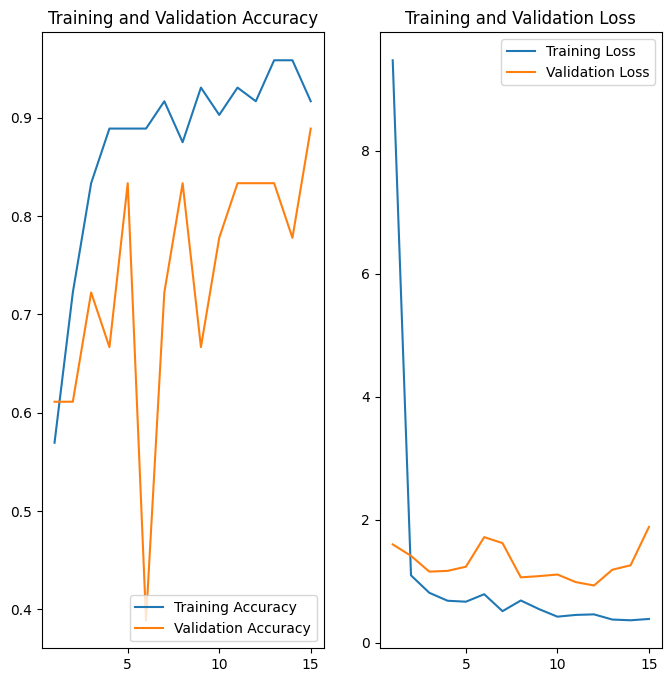

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model seems to perform slightly better. A couple of other variations of regularization techniques were also tried but didn't seem to provide much better performance. The lack of better performance could simply be attributed to the dataset containing very few images for training purposes. A better strategy to pursue could be to find a more comprehensive dataset.

For now, let us test the best model that we have for this dataset.

Load the model that was saved during training and test it on a couple of sample images to see if it can classify them.

In [1]:
from tensorflow import keras

model = keras.models.load_model('model_weights.h5.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
This image is 0.01% fracture and 99.99% non-fracture.


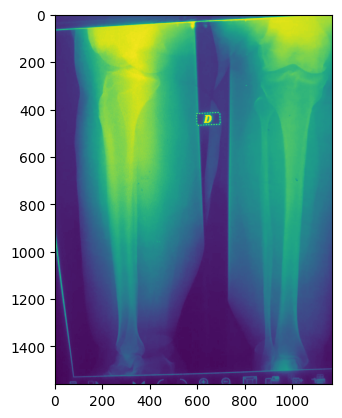

In [17]:
img = keras.utils.load_img(
    "/content/drive/MyDrive/FractureXRayImages/non fractured/334907671_900591471145602_19232666719356309_n.jpg",
    target_size=(img_height, img_width),
    color_mode="grayscale")
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% fracture and {100 * score:.2f}% non-fracture.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This image is 99.97% fracture and 0.03% non-fracture.


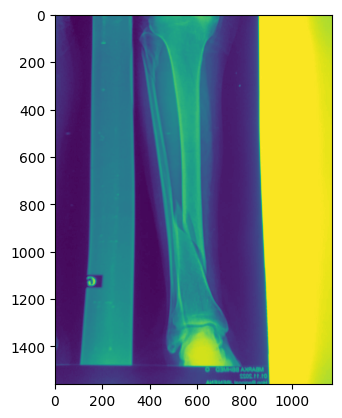

In [18]:
img = keras.utils.load_img(
    "/content/drive/MyDrive/FractureXRayImages/fractured/324466780_523598076537174_8225382673418570145_n.jpg",
    target_size=(img_height, img_width),
    color_mode="grayscale")
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% fracture and {100 * score:.2f}% non-fracture.")